In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from astropy.io import fits
import warnings
from scipy import optimize
# import muse_tools as mt
import matplotlib.pyplot as plt
from astropy.stats import gaussian_sigma_to_fwhm
from telassar import PVSlice
import astropy.units as u



def gauss2D(amp, x0, y0, xsig, ysig):
    return lambda x, y: amp * np.exp(-(((x0 - x)/xsig)**2 +
                                       ((y0 - y)/ysig)**2)/2)

def moments(data):
    total = np.abs(data).sum()
    Y, X = np.indices(data.shape)
    y = np.argmax((X * np.abs(data)).sum(axis = 1) / total)
    x = np.argmax((Y * np.abs(data)).sum(axis = 0) /total)
    col = data[int(y), :]
    row = data[:, int(x)]
    xwidth = np.sqrt(np.abs((np.arange(col.size) - y)*col).sum() / 
                     np.abs(col).sum())
    ywidth = np.sqrt(np.abs((np.arange(row.size) - x)*row).sum() /
                     np.abs(row).sum())
    height = data.max()
    mom = np.array([ywidth, xwidth])
    return height, y, x, ywidth, xwidth

def fitgauss(data):
    params = (moments(data))
    errorfunction = lambda p: np.ravel(gauss2D(*p)(*np.indices(data.shape)) - data)
    p, success = optimize.leastsq(errorfunction, x0 = params)
    return p

In [5]:
f = fits.open('../SII_rotated.fits')[0]
             #'../multigauss/SII_rotated.fits')[0]
                #'muse_sii.fits')[0]
data = f.data
hdr = f.header

muse_pv = np.sum(data[:, :, 19:29], axis = 2).T
xshoo_pv = fits.open('data/HD163296_SIIF_6730.fits')[0]
xsh_data = xshoo_pv.data
xsh_hdr = xshoo_pv.header
muse_pv

array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [ -10.03974191,   24.49826967, -106.15239295, ...,  -61.67313515,
         -31.23979696,   48.96889265],
       [ -83.74446989,   85.57126947,  -13.0958981 , ...,   24.4699877 ,
         -28.2617905 ,  100.15297533],
       [   5.25959797,   49.75766133,   86.67839884, ...,  -24.78481314,
          30.41639345,  204.35429802]])

<IPython.core.display.Javascript object>


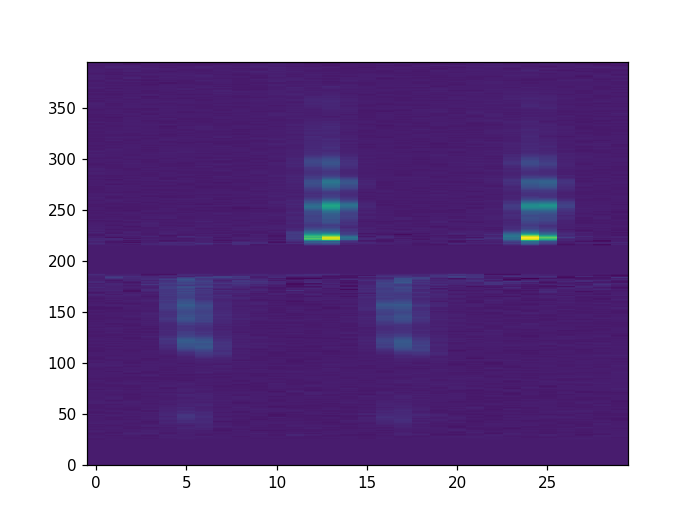

In [39]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.imshow(muse_pv, origin = 'lower', aspect = 'auto')

In [71]:
muse_sii = PVSlice(data = muse_pv, header=hdr)
xshoo_sii = PVSlice('data/HD163296_SIIF_6730.fits')


In [116]:
muse_sii.world.offset2pix(0, nearest=True)

197

<IPython.core.display.Javascript object>


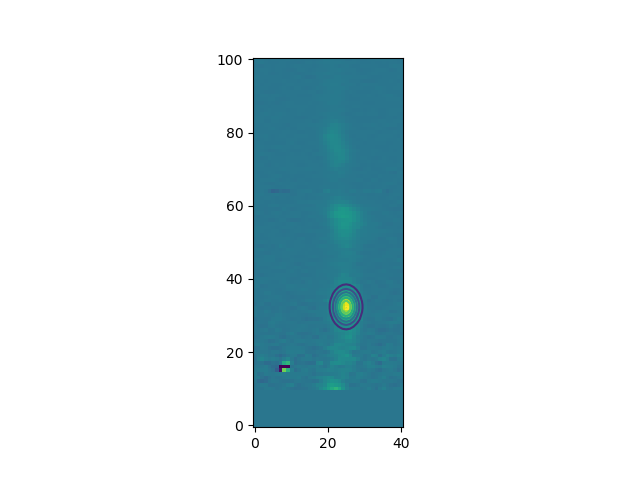

[3.52816464e-16 3.23795895e+01 2.49408304e+01 3.08250830e+00
 2.23585760e+00]


In [79]:
%matplotlib notebook

plt.imshow(data[140:241, 60:101], origin = 'lower')
plt.contour(fit(Y, X))
print(p)

In [74]:
xshoo2 = xshoo_sii.spectral_window(vmin = -400, vmax = 390, unit = u.Unit('km/s'))
#test = pv.spectral_window(vmin = 200, vmax = 300, unit = u.Unit('km/s'))

#pv2 = pv2.data * 1e16
#new_pv += np.abs(new_pv.min())
#new_pv.max()
xshoo2.world


WCS Keywords

Number of WCS axes: 2
CTYPE : 'OFFSET'  'VELO'  
CRVAL : -25.3  -395.354586567  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.2  6.68566370727  
NAXIS : 330  119

In [41]:
lines = {
        'OI6300':   [6300.304, 'Angstrom', r'$[\mathrm{OI}]\lambda 6300\AA$'],
        'OI6363':   [6363.777, 'Angstrom', r'$[\mathrm{OI}]\lambda 6363\AA$'],
        'NII6548':  [6548.04, 'Angstrom', r'$[\mathrm{NII}]\lambda 6548\AA$'],
        'NII6583':  [6583.46,  'Angstrom', r'$[\mathrm{NII}]\lambda 6583\AA$'],
        'HAlpha':   [6562.8,  'Angstrom', r'$\mathrm{H}\alpha$'],
        'HBeta':    [4861.325,  'Angstrom', r'$\mathrm{H}\beta$'],
        'SII6716':  [6716.44,  'Angstrom', r'$[\mathrm{SII}]\lambda 6716\AA$'],
        'SII6731':  [6730.81,  'Angstrom', r'$[\mathrm{SII}]\lambda 6730\AA$'],
        'CaII7291': [7291.47, 'Angstrom', r'$[\mathrm{CaII}]\lambda 7291\AA$'],
        'CaII7324': [7323.89, 'Angstrom', r'$[\mathrm{CaII}]\lambda 7324\AA$']
}



39.473242268352
22
395
(11190,)
(373, 30)


<IPython.core.display.Javascript object>


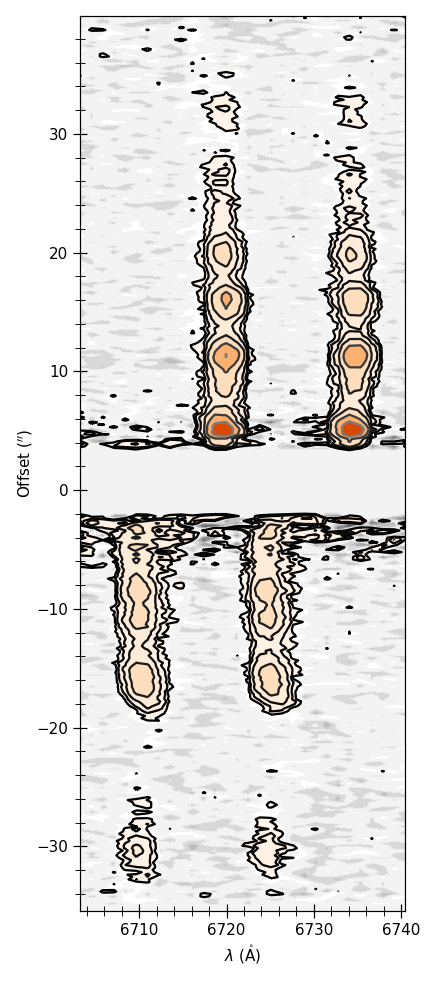

61.15070054856758


In [13]:
mx = muse_sii.world.get_spatial_end()
print(mx)
muse_sii2 = muse_sii.spatial_window(amin = -35., amax = mx, unit = u.Unit('arcsec'))
muse_sii2.world
muse_sii2.plot_contours()
#ax = plt.gca()
#ax.set_aspect('auto')
#plt.axvline(x= 6730.81)
#plt.axvline(x = 6716.44)

In [27]:
%matplotlib notebook

sigma = 61.15070054856758

1.25 * sigma / muse_sii2.max()

0.010609895233061944

To run a test on how to get proper contour scales, let's try an exercise. 

We know we want the contours to start between 3-5 sigma, which will probably be around 1.5% of the maximum intensity of the data. We're trying a root(2) log scale:

`lvls = np.array([sigma * 2 * sqrt(2)**i for i in range(a, b, N)])`

To avoid clipping of the contours, we want the top contour level to correspond to 100% of the maximum intensity of the data. So our min/max scaling factors are 0.015 and 1.

From the above:

$$ L = 2 \sigma \sqrt{2}^n = 2 \sigma * 2^{n/2}$$
$$ L = \sigma 2^{n/2 + 1} $$

Rearranging to solve for the exponents:

$$\ln({L}) = \ln({\sigma 2^{n/2 + 1}}) $$

$$ \ln(L) = \ln(2 \sigma) + \frac{1}{2} n \ln(2) $$

Assuming $\sigma$ is positive:

$$ n = \frac{2 \ln(L/\sigma)}{\ln(2)} - 2 $$

Knowing that $L_i = 0.015$ and $L_f = 1$, we can solve for the upper and lower bounds of our exponents:

In [105]:
def exponent(L, sigma):
    
    # np.log is natural log
    n = (2 * np.log(3 * L/sigma) / np.log(2)) - 4
    
    return n

exp = lambda l, sig : (2 * np.log(3 * l/sig) / np.log(2)) - 4
l1 = 0.017 * muse_sii2.max()
l2 = 1. * muse_sii2.max()
sig2 = 3.851524896285758e-18

l3 = 0.017 * xshoo2.max()
l4 = 1. * xshoo2.max()

n0 = exp(l1, sigma)
n1 = exp(l2, sigma)
n2 = exp(l3, sig2)
n3 = exp(l4, sig2)
print(n0, n1)
print(n2, n3)

test = 2 * sigma * np.sqrt(2)**2
test2 = 2 * sig2 * np.sqrt(2)**n3

xp = np.linspace(n0, n1, 7)

t2 = (4/3) * sigma * np.sqrt(2)**xp
print(t2 / muse_sii2.max())

1.1740298629528532 12.930672749776349
0.6910843878693376 12.447727274692834
[0.017      0.03352541 0.06611489 0.13038405 0.25712816 0.50707806
 1.        ]


In [92]:
%timeit exponent(l2, sigma)
%timeit exp(l2, sigma)

3.7 µs ± 57.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.56 µs ± 19 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


[autoreload of telassar.plotter failed: Traceback (most recent call last):
  File "/home/katholikosophis/anaconda3/envs/astroconda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/katholikosophis/anaconda3/envs/astroconda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/katholikosophis/anaconda3/envs/astroconda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/katholikosophis/anaconda3/envs/astroconda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: get_contour_levels() requires a code object with 0 free vars, not 1
]


<IPython.core.display.Javascript object>


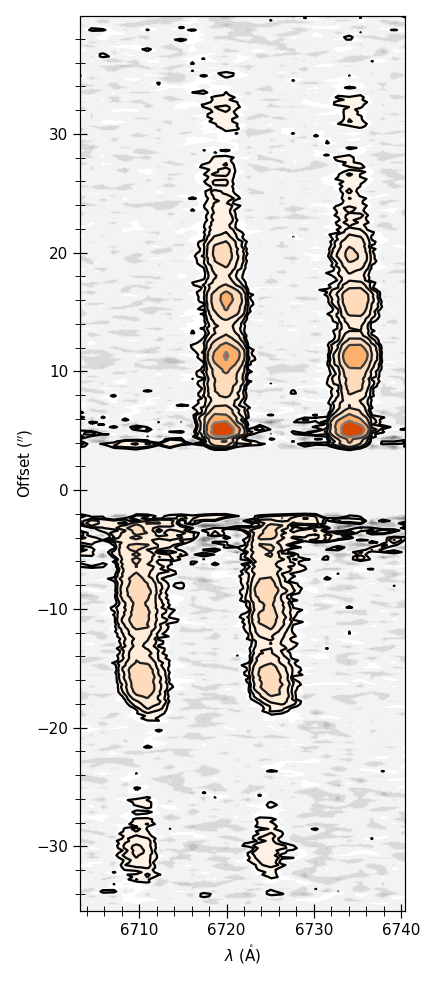

60.846479594274314


In [142]:
#xshoo_sii = xshoo_sii.spectral_window(vmin = -400, vmax=390, unit = u.Unit('km/s'))
#xshoo2.plot_contours()
muse_sii2.plot_contours()

In [284]:
print((np.linspace(60.8*(2), 1.1 * muse_sii.max(), 7)))
print(lvls[0])

[ 121.6        1422.14771474 2722.69542948 4023.24314422 5323.79085896
 6624.3385737  7924.88628844]
[ 121.69295919  243.38591838  486.77183675  973.54367351 1947.08734702
 3894.17469403 7788.34938807]


In [308]:
testlvls

array([0.01697583, 0.03395166, 0.06790333, 0.13580666, 0.27161332,
       0.54322664, 1.08645327])